### Network #01

In [ ]:
from collections import defaultdict
import pandas as pd
import networkx as nx

# 1. Read the data and create a dict with the drugs and yours active principles.
data = pd.read_csv('data.csv', sep=';', encoding='latin1')
data = data[~data['PRINCIPIO_ATIVO'].isna()]

drug_ingredients = defaultdict(set)
drug_categories = {}

def add_drug_ingredient(row):
    drug_name = row['NOME_PRODUTO']
    ingredients = [ingredient.strip() for ingredient in row['PRINCIPIO_ATIVO'].split('+')]
    drug_ingredients[drug_name].update(ingredients)
    drug_categories[drug_name] = row['CATEGORIA_REGULATORIA']

data.apply(add_drug_ingredient, axis=1)

# 2. Create the graph, add the drugs as graph nodes and then calculate the assortativity
G = nx.Graph()
for drug_name, ingredients in drug_ingredients.items():
    G.add_node(drug_name, category=drug_categories[drug_name])

drugs = list(drug_ingredients.keys())
for i in range(len(drugs)):
    for j in range(i + 1, len(drugs)):
        if any(ingredient_2 in drug_ingredients[drugs[i]] for ingredient_2 in drug_ingredients[drugs[j]]):
            G.add_edge(drugs[i], drugs[j])

assortativity = nx.attribute_assortativity_coefficient(G, 'category')
print(f"Assortatividade baseada na categoria regulatória: {assortativity}")

# 4. Based on assortativty calculus, answer the question
if assortativity > 0:
    print("Drugs in the same regulatory category tend to share active ingredients.")
elif assortativity < 0:
    print("Drugs from different regulatory categories tend to share active ingredients.")
else:
    print("There is no clear trend in the co-occurrence of active ingredients based on regulatory category.")

Assortatividade baseada na categoria regulatória: 0.35544657727138873
Medicamentos da mesma categoria regulatória tendem a compartilhar princípios ativos.


### Network #01 - Reduced Version

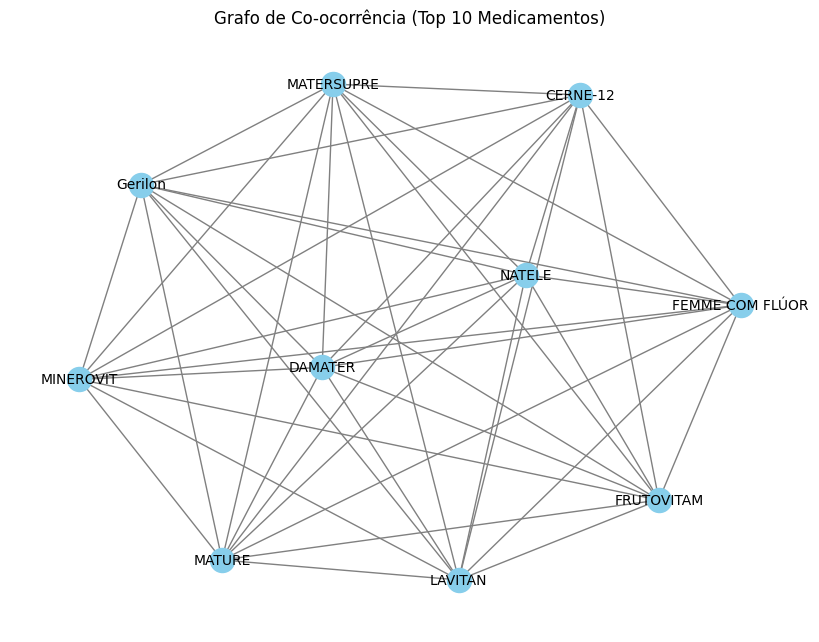

In [ ]:
from collections import defaultdict
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Generate a top ten sorted drugs graph based on the earlier code
num_top_nodes = 10
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:num_top_nodes]
subgraph_nodes = [node for node, degree in top_nodes]

# Create a subgraph
subgraph = G.subgraph(subgraph_nodes)

# Visualize the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_size=300, font_size=10, node_color="skyblue", edge_color="gray")
plt.title("Grafo de Co-ocorrência (Top {} Medicamentos)".format(num_top_nodes))
plt.show()

# If you want to calculate this top ten graph assortativty, use the earlier code and adapt

### Network #02

In [ ]:
import pandas as pd
import networkx as nx

# Load the data
data = pd.read_csv('data.csv', sep=';', encoding='latin1')

# Create a biparted graph
B = nx.Graph()

# Iterate over data and create the nodes and edges between active ingredients and drugs
for _, row in data.iterrows():
    medicamento = row['NOME_PRODUTO']
    principios_ativos = row['PRINCIPIO_ATIVO'].split('+') if pd.notna(row['PRINCIPIO_ATIVO']) else []

    B.add_node(medicamento, bipartite=0)

    for principio_ativo in principios_ativos:
        principio_ativo = principio_ativo.strip()
        B.add_node(principio_ativo, bipartite=1) 
        B.add_edge(medicamento, principio_ativo)

# Calculate assortativty
assortatividade_grau = nx.degree_assortativity_coefficient(B)

print(f"Assortatividade por grau no grafo bipartido: {assortatividade_grau}")

# Asnwer the question
if assortatividade_grau > 0:
    print("Active ingredients shared by complex drugs tend to bind to drugs with similar complexity profiles.")
else:
    print("Active ingredients shared by complex drugs do NOT tend to bind to drugs with similar complexity profiles.")

Assortatividade por grau no grafo bipartido: -0.18300057790965452
Princípios ativos compartilhados por medicamentos complexos NÃO tendem a se conectar a medicamentos com perfis de complexidade semelhante.


### REDE #02 - Versão reduzida para melhor visualização do grafo

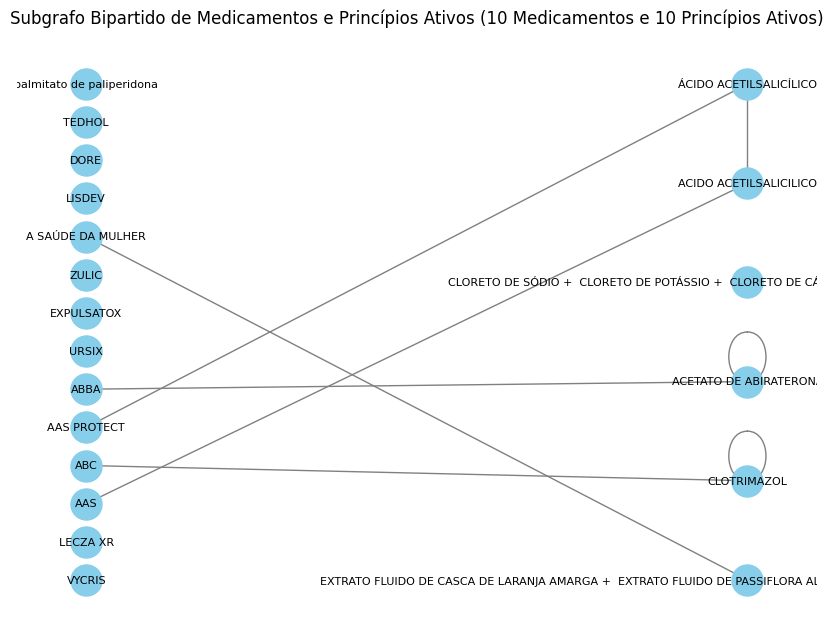

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Carregar os dados
data = pd.read_csv('data.csv', sep=';', encoding='latin1')

# Filtrar colunas relevantes: Nome do medicamento e princípios ativos
medicamentos = data[['NOME_PRODUTO', 'PRINCIPIO_ATIVO']]

# Criar o grafo bipartido
B = nx.Graph()

# Adicionar nós e arestas no grafo bipartido
for idx, row in medicamentos.iterrows():
    if pd.notna(row['PRINCIPIO_ATIVO']):
        med = row['NOME_PRODUTO']
        principios = [p.strip() for p in str(row['PRINCIPIO_ATIVO']).split(',')]
        B.add_node(med, bipartite=0)  # Nó medicamento
        for principio in principios:
            B.add_node(principio, bipartite=1)  # Nó princípio ativo
            B.add_edge(med, principio)  # Aresta entre medicamento e princípio ativo

# Limitar o gráfico a um subconjunto menor (exemplo: 10 medicamentos e 10 princípios ativos)
most_common_meds = list(dict(B.degree()).items())[:10]  # 10 medicamentos mais conectados
most_common_principles = list(dict(B.degree()).items())[-10:]  # 10 princípios ativos mais conectados

# Filtrar o grafo para incluir apenas nós selecionados
subgraph_nodes = set([med for med, _ in most_common_meds] + [principle for principle, _ in most_common_principles])
subgraph = B.subgraph(subgraph_nodes)

# Visualização do subgrafo bipartido
plt.figure(figsize=(8, 6))

# Definir layout bipartido
pos = nx.bipartite_layout(subgraph, [n for n, d in subgraph.nodes(data=True) if d.get('bipartite') == 0])

# Desenhar o subgrafo
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    node_size=500,
    font_size=8,
    node_color="skyblue",
    edge_color="gray"
)

plt.title('Subgrafo Bipartido de Medicamentos e Princípios Ativos (10 Medicamentos e 10 Princípios Ativos)')
plt.show()


### REDE #03


In [ ]:
import pandas as pd
import networkx as nx

# Carregar os dados
data = pd.read_csv('data.csv', sep=';', encoding='latin1')

# 1. Criar o grafo de co-ocorrência:
G = nx.Graph()

# Adicionar nós (medicamentos) e arestas (compartilhamento de princípios ativos)
for nome_produto, grupo in data.groupby('NOME_PRODUTO'):
    # Verificar se 'PRINCIPIO_ATIVO' está presente e não é nulo
    if 'PRINCIPIO_ATIVO' in grupo and pd.notna(grupo['PRINCIPIO_ATIVO'].iloc[0]):
        principios_ativos = grupo['PRINCIPIO_ATIVO'].str.split('+').explode().str.strip().unique()

        # Usar os nomes de coluna corretos:
        node_attributes = {
            'LABORATORIO': grupo['EMPRESA_DETENTORA_REGISTRO'].iloc[0],  # Usando 'EMPRESA_DETENTORA_REGISTRO'
            'CLASSE_TERAPEUTICA': grupo['CLASSE_TERAPEUTICA'].iloc[0]  # Usando 'CLASSE_TERAPEUTICA'
        }

        G.add_node(nome_produto, **node_attributes)
        for i in range(len(principios_ativos)):
            for j in range(i + 1, len(principios_ativos)):
                G.add_edge(principios_ativos[i], principios_ativos[j])

# 2. Calcular a assortatividade:
assortatividade_laboratorio = nx.attribute_assortativity_coefficient(G, 'LABORATORIO')
assortatividade_classe = nx.attribute_assortativity_coefficient(G, 'CLASSE_TERAPEUTICA')

# 3. Imprimir os resultados:
print(f"Assortatividade por Laboratório: {assortatividade_laboratorio}")
print(f"Assortatividade por Classe Terapêutica: {assortatividade_classe}")

# 4. Responder à pergunta:
if assortatividade_laboratorio > 0:
    print("Medicamentos do mesmo laboratório tendem a compartilhar mais princípios ativos.")
else:
    print("Medicamentos do mesmo laboratório não tendem a compartilhar mais princípios ativos.")

if assortatividade_classe > 0:
    print("Medicamentos da mesma classe terapêutica tendem a compartilhar mais princípios ativos.")
else:
    print("Medicamentos da mesma classe terapêutica não tendem a compartilhar mais princípios ativos.")

Assortatividade por Laboratório: 0.003980110924887403
Assortatividade por Classe Terapêutica: 0.015859575725516797
Medicamentos do mesmo laboratório tendem a compartilhar mais princípios ativos.
Medicamentos da mesma classe terapêutica tendem a compartilhar mais princípios ativos.


### REDE #03 - Versão reduzida para melhor visualização do grafo

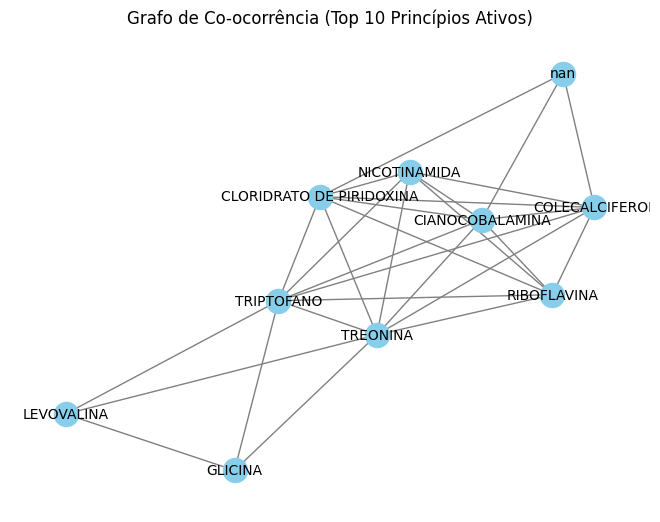

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ... (código para carregar dados e criar o grafo G)

# 3. Visualizar o grafo (versão menor):

# Selecionar um subconjunto de nós (exemplo: top 10 mais conectados)
num_top_nodes = 10  # Número de nós principais a serem incluídos
top_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:num_top_nodes]
subgraph_nodes = [node for node, degree in top_nodes]

# Criar o subgrafo com os nós selecionados
subgraph = G.subgraph(subgraph_nodes)

# Definir o layout (pode usar spring_layout, circular_layout, etc.)
pos = nx.spring_layout(subgraph)

# Desenhar o subgrafo
nx.draw(subgraph, pos, with_labels=True, node_size=300, font_size=10,
        node_color="skyblue", edge_color="gray")
plt.title("Grafo de Co-ocorrência (Top {} Princípios Ativos)".format(num_top_nodes))
plt.show()

# ... (restante do código)